### Road Load Calculations

In [6]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import hw_utils
import matplotlib_inline
from scipy.integrate import solve_ivp

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# constants
G = 9.81  # m/s^2
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    rho=1.2,  # hardcoding in air density near sea level [kg/m^3]
)

mps_per_kph = 0.2777777  # 1kph = 0.27777777 mps

eta_motor = 0.9
eta_bop = 0.92  # "Balance Of Plant" efficiency

# constant velocities from 40 to 120 km/h
speeds = np.arange(40, 120.5, 0.5)

cycle = dict(time=np.arange(0, 60), mps=speeds * mps_per_kph)


# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(
    t, y, cycle, vehicle, amb, index
):  # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"], cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, cycle["time"], cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    C_roll = vehicle["C_roll_0"]

    term = (
        vehicle["mass"] * (dv_vehdt + G * np.sin(alpha) + C_roll * G * np.cos(alpha))
        + vehicle["C_drag"]
        * vehicle["A_front"]
        * 0.5
        * amb["rho"]
        * (v_veh - amb["v_air"]) ** 2
    )
    Wdot_veh = (max(0, term)) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = vehicle["eta_pt"](Wdot_veh / 1000)
    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0


def calculate_loads(vehicle):
    for idx, speed in enumerate(cycle["mps"]):
        time = cycle["time"]
        arr_length = len(time)

        #  driving cycle vehicle velocities [m/s]
        cycle["v_veh"] = [speed] * arr_length
        # road angle to horizontal  [deg.]
        cycle["alpha"] = [0] * arr_length
        # Calculate vehicle acceleration and identify times when acceleration is positive, zero for this problem
        cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

        # Call an ODE integrator to solve for y(t)
        sol = solve_ivp(
            dydt_vehicle,
            [0, time[-1] + 1],
            y_0,
            "RK45",
            time,
            args=(cycle, vehicle, ambient, index),
            rtol=1e-4,
            atol=1e-4,
        )

        vehicle["x"][idx] = sol.y[index["x"]] / 1000
        vehicle["E_veh"][idx] = sol.y[index["E_veh"]] / 1000
        vehicle["E_fuel"][idx] = sol.y[index["E_fuel"]] / 1000
        vehicle["kmperliter"][idx] = [0] * arr_length
        vehicle["kmperliter"][idx] = (
            1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)
        )
        vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

        #  Allocate memory for vectors for calculating vehicle power requirements
        vehicle["Wdot_drag"][idx] = np.zeros(arr_length)
        vehicle["Wdot_roll"][idx] = np.zeros(arr_length)
        vehicle["Wdot_accel"][idx] = np.zeros(arr_length)

        # Calculate instantaneous power (in kW) to overcome forces on vehicle
        #   and integrate to get total work required (in kWh)
        vehicle["Wdot_drag"][idx] = (
            (
                np.array(
                    vehicle["C_drag"]
                    * vehicle["A_front"]
                    * 0.5
                    * ambient["rho"]
                    * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
                )
            )
            * cycle["v_veh"]
            / 1000
        )

        C_roll = vehicle["C_roll_0"]
        vehicle["Wdot_roll"][idx] = (
            vehicle["mass"]
            * C_roll
            * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
        )
        vehicle["Wdot_accel"][idx] = vehicle["mass"] * (
            np.array([max(0, dv_dt) for dv_dt in cycle["dv_vehdt"]])
            * cycle["v_veh"]
            / 1000
        )
        vehicle["Wdot_access_vec"][idx] = (
            np.ones(arr_length) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
        )
        vehicle["Wdot"][idx] = (
            vehicle["Wdot_drag"][idx]
            + vehicle["Wdot_roll"][idx]
            + vehicle["Wdot_accel"][idx]
            + vehicle["Wdot_access_vec"][idx]
        )

    return vehicle

# Fuel Cell HDV


In [31]:
eta_motor = 0.9
eta_bop = 0.92
eta_elec = 0.95


def eta_h2_powertrain(wdot_veh):
    return eta_motor * eta_bop * eta_elec


vehicle_fcev_hdv = dict(
    mass=28000,
    C_drag=0.65,
    A_front=11.5,
    C_roll_0=0.005,
    Wdot_access=500,
    eta_elec=eta_elec,
    eta_pt=eta_h2_powertrain,
    # To be filled in later
    Wdot_drag=[0] * len(speeds),
    Wdot_roll=[0] * len(speeds),
    Wdot_accel=[0] * len(speeds),
    Wdot_access_vec=[0] * len(speeds),
    Wdot=[0] * len(speeds),
    x=[0] * len(speeds),
    E_veh=[0] * len(speeds),
    E_fuel=[0] * len(speeds),
    kmperliter=[0] * len(speeds),
    mpg=[0] * len(speeds),
)
vehicle_fcev_hdv = calculate_loads(vehicle_fcev_hdv)

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_939/2560101826.py:102: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


$ $ 

### Figuring out range of FCEV

We know the power out of the fuel cell stack is governed by this equation:

$
\dot w_{fuel} = \dot w_{veh} \cdot \eta_{BOP} \cdot \eta_{motor} \cdot \eta_{elec} = V \cdot I = (V_0 - J \cdot ASR) \cdot J \cdot A_{cell} \cdot n_{cell}
$

$
\hspace{2cm} \mathrm{where\hspace{0.2cm}} V_{0} = 0.9\mathrm{V}, ASR = 0.15\mathrm{\Omega \cdot {cm^2}}, n_{cell} = 400, A_{cell}=500\mathrm{cm^2}, \eta_{BOP} = 0.92, \eta_{motor}=0.9, \eta_{elec} = 0.95
$

This is a quadratic equation where we will solve for the current density (J).

$
0 = [{-ASR \cdot A_{cell} \cdot n_{cell}}]\cdot J^2 + [V_0 \cdot A_{cell} \cdot n_{cell}] \cdot J - \dot w_{fuel} 
$

From current density, we can solve for the rate of fuel consumption of the H<sub>2</sub>.

$
\dot m_{H_2} = \dfrac{J \cdot A_{cell} \cdot n_{cell} \cdot M_{H_2}} {2\cdot F \cdot \varepsilon_{H_2}}   
$

$
\hspace{2 cm} \mathrm{where}\  M_{H_2}=0.002016 \mathrm{\tfrac{kg}{mol}}\ \mathrm{is\ the\ molar\ mass\ of\ hydrogen}, F=96,485.33 \mathrm{\tfrac{C}{mol}\ is\ Faraday's\ constant}, \varepsilon_{H_2}\approx 1\ \mathrm{for\ a\ PEMFC}
$

Then we find how how much times passes for the 6 kg tank to empty by solving for *Time To Empty* below.

$
\int_0^{Time\ To\ Empty} \dot{m}\  \mathrm{d}t = 10\mathrm{kg}
$

And then we can get range by multiply *Time to Empty* by the speed, **not forgetting to square away the units**.

$
range = Time\ to\ Empty \times speed
$



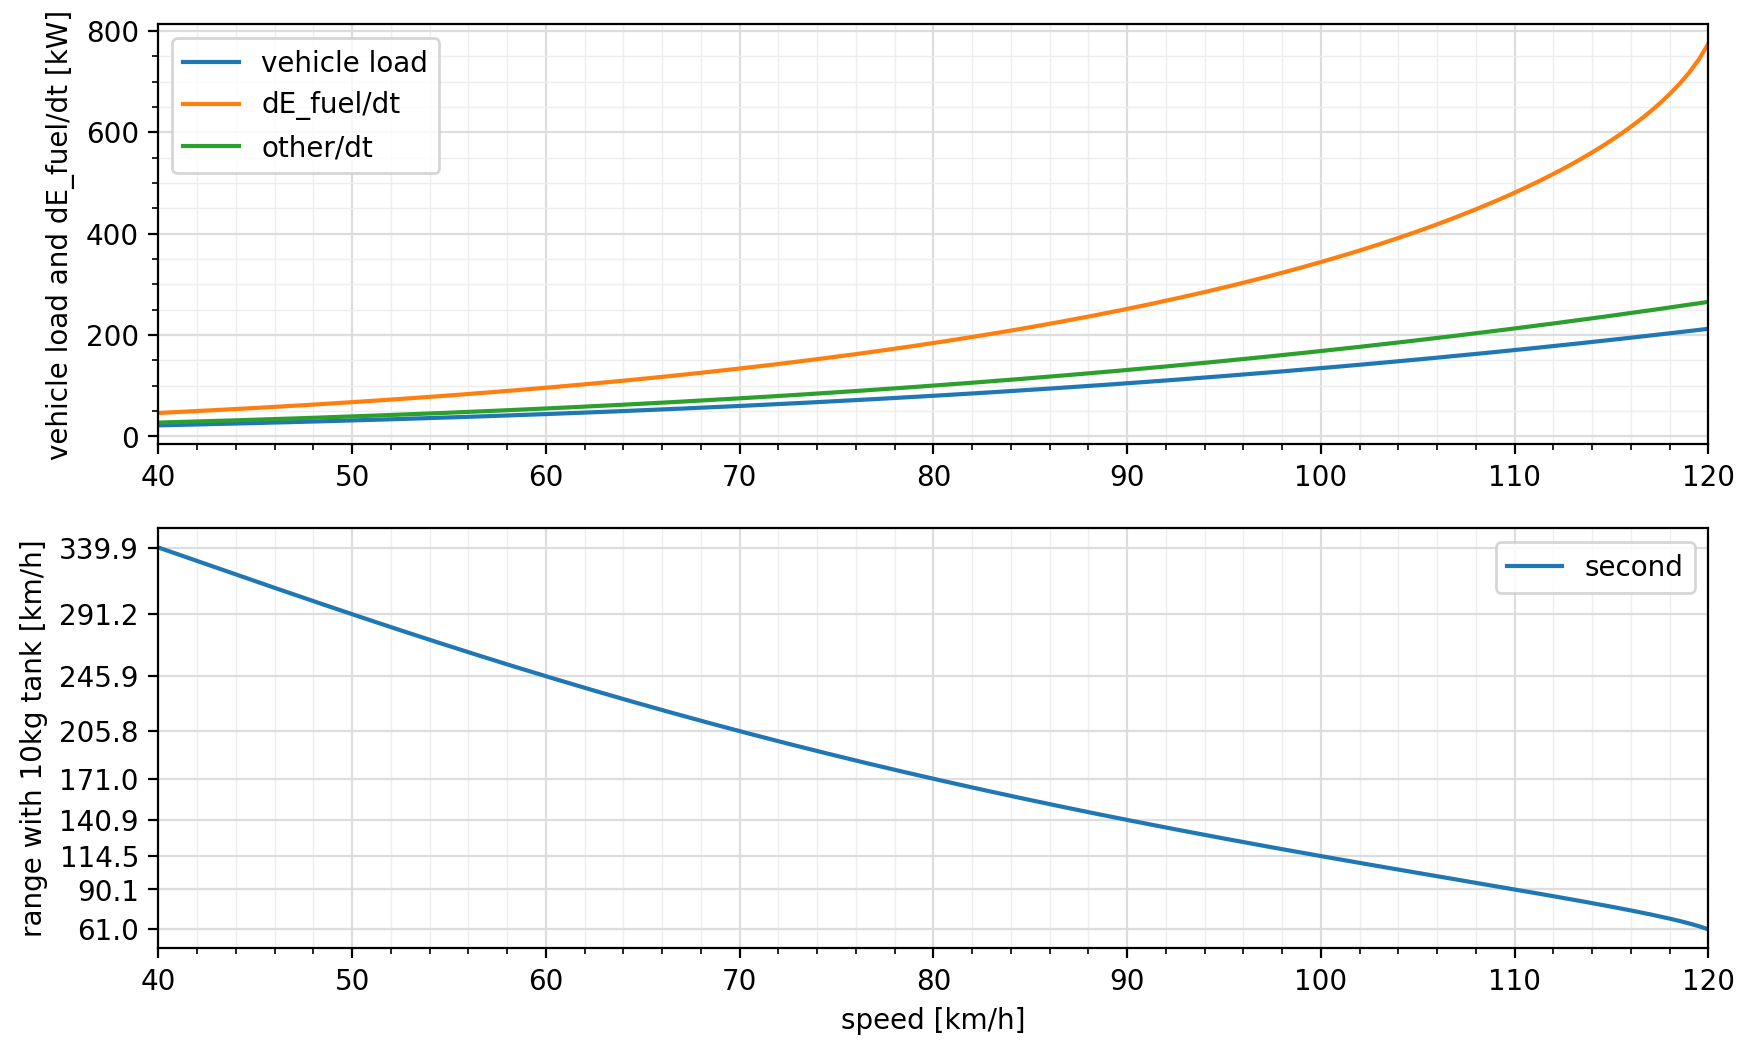

In [67]:
asr = 0.15
v_0 = 0.9
n_cell = 400
A_cell = 500
M_h2 = 0.002016
F = 96_485.33
tank_size = 10
HHV_h2 = 286e3  # kJ/mol


fuel_cell_wdot_out = [max(arr) / 60 for arr in vehicle_fcev_hdv["E_fuel"]]
fuel_cell_dEdt_in = []
fuel_cell_current_densities = []

for p in fuel_cell_wdot_out:
    current_density = np.min(
        np.roots(
            [
                -asr * A_cell * n_cell,
                v_0 * A_cell * n_cell,
                -p * 1000,
            ]
        )
    )
    fuel_cell_current_densities = [*fuel_cell_current_densities, current_density]
    fuel_cell_input_power_watts = current_density * A_cell * n_cell * HHV_h2 / (2 * F)
    fuel_cell_input_power_kw = fuel_cell_input_power_watts / 1000
    fuel_cell_dEdt_in = [*fuel_cell_dEdt_in, fuel_cell_input_power_kw]


fcev_ranges = []
fcev_ranges2 = []
y_ticks = []
# p in kw
for idx, j in enumerate(fuel_cell_current_densities):
    V_cell = 0.9 - (j * asr)
    dE_fuel = V_cell * tank_size * 2 * F / M_h2
    rng = (speeds[idx] / 3600) * (dE_fuel) / (fuel_cell_wdot_out[idx] * 1000)

    m_dot = j * A_cell * n_cell * M_h2 / (2 * F)
    time_to_empty_in_sec = tank_size / m_dot
    time_to_empty_in_hours = time_to_empty_in_sec / (60 * 60)
    rng2 = speeds[idx] * time_to_empty_in_hours
    
    # print(rng2)

    fcev_ranges = [*fcev_ranges, rng]
    fcev_ranges2 = [*fcev_ranges2, rng2]
    if speeds[idx] % 10 == 0:
        y_ticks = [*y_ticks, rng]


fig, axs = plt.subplots(2, figsize=(10, 6))
axs[0].plot(speeds, [max(w) for w in vehicle_fcev_hdv["Wdot"]], label="vehicle load")
axs[0].plot(speeds, fuel_cell_dEdt_in, label="dE_fuel/dt")
axs[0].set_ylabel("vehicle load and dE_fuel/dt [kW]")
# axs[1].plot(speeds, fcev_ranges)
axs[1].plot(speeds, fcev_ranges2, label="second")
axs[1].set_xlabel("speed [km/h]")
axs[1].set_ylabel("range with 10kg tank [km/h]")
axs[1].set_yticks(y_ticks)
for ax in axs:
    hw_utils.nice_grid(ax)
    ax.legend()
    ax.set_xlim(min(speeds), max(speeds))